In [1]:
import torch
from fourier_scaffold import (
    FourierScaffold,
    HammardSharpening,
    HammardShift,
    HammardShiftMatrix,
    HammardSharpening,
    ContractionSharpening,
    GaussianFourierSmoothing,
    GuassianFourierSmoothingMatrix,
)
from graph_utils import fourier_plot_probabilities_complex

/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash_functions.py:1: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.special


In [ ]:
shapes = [[5, 5], [7, 7]]
device = "cuda"
scaffold = FourierScaffold(
    shapes=torch.tensor(shapes),
    D=1000**2,
    smoothing=GaussianFourierSmoothing(kernel_radii=[10] * 2, kernel_sigmas=[0.4] * 2),
    device=device,
)

In [ ]:
scaffold.velocity_shift(v=torch.tensor([1, 1]))

In [ ]:
scaffold.smooth()

In [ ]:
scaffold.sharpen()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_ylim(0,1)
fourier_plot_probabilities_complex(scaffold, ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_ylim(0,1)
fourier_plot_probabilities_complex(scaffold, ax)
plt.show()

In [ ]:
import itertools

for i, k in enumerate(
    itertools.product(
        *[list(range(scaffold.shapes[:, i].prod())) for i in range(scaffold.d)]
    )
):
    p = scaffold.get_probability(torch.tensor(k, device=scaffold.device))
    print(p)


In [2]:
shapes = [[5, 5], [7, 7]]
device = "cuda"
scaffold = FourierScaffold(
    shapes=torch.tensor(shapes),
    D=1000,
    smoothing=GuassianFourierSmoothingMatrix(kernel_radii=[10] * 2, kernel_sigmas=[0.4] * 2),
    sharpening=ContractionSharpening(2),
    shift=HammardShiftMatrix(),
    device=device,
    representation='matrix'
)


/home/ezrahuang/Projects/rl-research/vectorhash/fourier_scaffold.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5],
        [7, 7]])
N_g (D) :  1000
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)


In [6]:
scaffold.smooth()

In [9]:
scaffold.sharpen()

In [11]:
print((scaffold.g * scaffold.psum_feature).sum())

tensor(1.+3.6181e-07j, device='cuda:0')


0 (0, 0) tensor(1.0017, device='cuda:0') tensor(7.6408e-11, device='cuda:0')
35 (1, 0) tensor(0.0124, device='cuda:0') tensor(-0.1990, device='cuda:0')
1190 (34, 0) tensor(0.0124, device='cuda:0') tensor(0.1990, device='cuda:0')


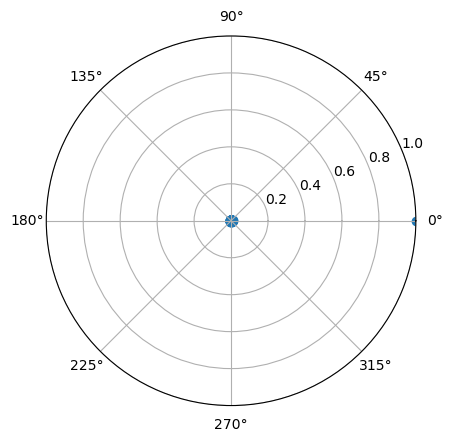

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_ylim(0,1)
fourier_plot_probabilities_complex(scaffold, ax)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_ylim(0,1)
fourier_plot_probabilities_complex(scaffold, ax, t=0.001)
plt.show()


In [ ]:
scaffold.velocity_shift(v=torch.tensor([1, 1]))

In [ ]:
import itertools

for i, k in enumerate(
    itertools.product(
        *[list(range(scaffold.shapes[:, i].prod())) for i in range(scaffold.d)]
    )
):
    p = scaffold.get_probability(torch.tensor(k, device=scaffold.device))
    print(p)